In [3]:
# https://colab.research.google.com/github/vsitzmann/siren/blob/master/explore_siren.ipynb

In [1]:
!pip install -U scikit-image
!pip install -U miplib

# 3D Plotting
'''
!pip install mayavi
!pip install PyQt5
!jupyter nbextension install --py mayavi --user
!jupyter nbextension enable --py mayavi --user
'''

Requirement already up-to-date: scikit-image in ./miniconda3/envs/thesis/lib/python3.7/site-packages (0.18.1)
Requirement already up-to-date: miplib in ./miniconda3/envs/thesis/lib/python3.7/site-packages (1.0.6)


'\n!pip install mayavi\n!pip install PyQt5\n!jupyter nbextension install --py mayavi --user\n!jupyter nbextension enable --py mayavi --user\n'

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize, ToPILImage
import numpy as np
import skimage
import matplotlib.pyplot as plt

import scipy

import time
import gc

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

!pip install gemmi
import gemmi

In [3]:
# https://github.com/sakoho81/miplib
# Install: https://pypi.org/project/miplib/

import miplib.analysis.resolution.fourier_ring_correlation as frc
import miplib.analysis.resolution.fourier_shell_correlation as fsc
from miplib.data.containers.fourier_correlation_data import FourierCorrelationDataCollection
import miplib.ui.plots.frc as frcplots
from miplib.ui.cli import miplib_entry_point_options as options
from miplib.data.containers.image import Image
import miplib.data.io.read as imread

In [4]:
from inspect import getmembers, isfunction
getmembers(frc, isfunction)

[('batch_evaluate_frc',
  <function miplib.analysis.resolution.fourier_ring_correlation.batch_evaluate_frc>),
 ('calculate_single_image_frc',
  <function miplib.analysis.resolution.fourier_ring_correlation.calculate_single_image_frc>),
 ('calculate_single_image_sectioned_frc',
  <function miplib.analysis.resolution.fourier_ring_correlation.calculate_single_image_sectioned_frc>),
 ('calculate_two_image_frc',
  <function miplib.analysis.resolution.fourier_ring_correlation.calculate_two_image_frc>)]

In [5]:
getmembers(imread, isfunction)

[('__bioformats', <function miplib.data.io.read.__bioformats>),
 ('__itk_image', <function miplib.data.io.read.__itk_image>),
 ('__itk_transform', <function miplib.data.io.read.__itk_transform>),
 ('__tiff', <function miplib.data.io.read.__tiff>),
 ('get_image', <function miplib.data.io.read.get_image>)]

In [6]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [10]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

--2021-03-24 16:27:10--  ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-30458/map/emd_30458.map.gz
           => ‘emd_30458.map.gz’
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.138
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.138|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/databases/emdb/structures/EMD-30458/map ... done.
==> SIZE emd_30458.map.gz ... 5219344
==> PASV ... done.    ==> RETR emd_30458.map.gz ... done.
Length: 5219344 (5.0M) (unauthoritative)

emd_30458.map.gz    100%[===================>]   4.98M  5.26MB/s    in 0.9s    

2021-03-24 16:27:13 (5.26 MB/s) - ‘emd_30458.map.gz’ saved [5219344]



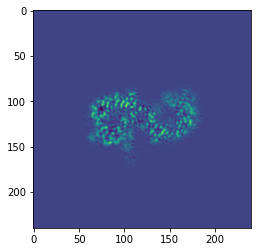

In [11]:
create_structure_from_scratch = False

if create_structure_from_scratch: 
    # Getting test rNLRP1-rDPP9 map
    map_filename = 'emd_30458.map.gz'
    map_path = map_filename.replace('.gz', '')
    if not os.path.exists(map_filename):
        !wget ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-30458/map/emd_30458.map.gz
    if not os.path.exists(map_path):
        !gunzip 'emd_30458.map.gz'

    # https://bioinformatics.stackexchange.com/questions/13079/ccp4-file-to-a-python-3-numpy-array-or-similar-workaround
    test_map = gemmi.read_ccp4_map('emd_30458.map')
    test_map.setup()  # optional

    raw_structure = np.array(test_map.grid, copy=False)
    plt.imshow(raw_structure[:, :, raw_structure.shape[0] // 2])
    
    structure = np.expand_dims(raw_structure, axis=-1)
    # structure = structure[50:-50, 50:-50, 50:-50, :]
    structure = scipy.ndimage.zoom(structure, (0.5, 0.5, 0.5, 1))
    
    with open('rNLRP1-rDPP9_original_structure_reduced.npy', 'wb') as f:
        np.save(f, structure)
else:
    structure = np.load('rNLRP1-rDPP9_original_structure_reduced.npy')

px_to_A = 1.06 # TRPV1 dataset specific

(120, 120, 120, 1)


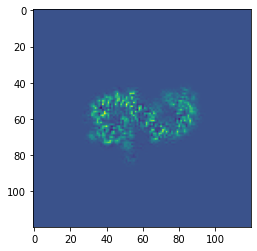

In [12]:
print(structure.shape)
plt.imshow(structure[:, :, structure.shape[0] // 2])

In [13]:
output_dims = structure.shape[0]

In [14]:
'''
class ImageFitting(Dataset):
    def __init__(self, img, sidelength):
        super().__init__()
        img = torch.from_numpy(img)
        # self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.pixels = img.reshape(-1, 1)
        self.coords = get_mgrid(sidelength, 3)

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels
'''
    
class ImageFitting(Dataset):
    def __init__(self, img, sidelength):
        super().__init__()
        img = torch.from_numpy(img)
        # self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.pixels = img.reshape(-1, 1)
        self.coords = get_mgrid(sidelength, 3)

    def __len__(self):
        return len(self.pixels)

    def __getitem__(self, idx):
        
            
        return self.coords[idx], self.pixels[idx]
    
# Clears memory
#################
torch.cuda.empty_cache()
gc.collect()
#################

particle_slice = ImageFitting(structure, output_dims)
dataloader = DataLoader(particle_slice, batch_size=256, pin_memory=True, num_workers=0)

siren_model = Siren(in_features=3, out_features=1, hidden_features=512, 
                  hidden_layers=7, outermost_linear=True)
siren_model.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=3, out_features=512, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
    (4): SineLayer(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
    (5): SineLayer(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
    (6): SineLayer(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
    (7): SineLayer(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
    (8): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [15]:
# GPU costs with input of (300, 300, 300, 1):
    # hidden_features=128, hidden_layers=3, outermost_linear=True
        # 12.88 GiB
    # hidden_features=64, hidden_layers=3, outermost_linear=True
        # 6.44 GiB

In [16]:
loss_vals = []

In [ ]:
total_steps = 1000 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 10

optim = torch.optim.Adam(lr=1e-6, params=siren_model.parameters())

# model_input, ground_truth = next(iter(dataloader))
# model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in range(total_steps):
    
    running_loss = 0.0
    
    epoch_loss = 0.0
    for batch, data in enumerate(dataloader):
        model_input, ground_truth = data
        model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
        
        optim.zero_grad()
    
        model_output, coords = siren_model(model_input)    
        loss = ((model_output - ground_truth)**2).mean()
        loss.backward()
        optim.step()

        epoch_loss += loss.item()
        '''
        running_loss += loss.item()
        # if not step % steps_til_summary:
        if batch % 400 == 399:
            print("Epoch: %d, Batch: %d, Loss %0.9f" % (step + 1, batch + 1, running_loss / 400))
            running_loss = 0.0
            # img_grad = gradient(model_output, coords)
            # img_laplacian = laplace(model_output, coords)
        '''

        '''
            fig, axes = plt.subplots(1,1, figsize=(18,6))
            axes.imshow(model_output.cpu().view(output_dims,output_dims).detach().numpy())
            # axes[1].imshow(img_grad.norm(dim=-1).cpu().view(256,256).detach().numpy())
            # axes[2].imshow(img_laplacian.cpu().view(256,256).detach().numpy())
            plt.show()
        '''
            
    epoch_loss /= len(dataloader)
    print("Epoch: %d, Loss %0.9f" % (step + 1, epoch_loss))
    loss_vals.append(epoch_loss)
    epoch_loss = 0.0

In [18]:
print(len(loss_vals))

1000


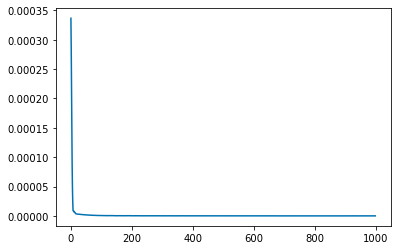

In [19]:
plt.plot(loss_vals)

In [17]:
print(len(loss_vals))

906


In [73]:
model_input, ground_truth = next(iter(dataloader))
model_input = model_input.cuda()
model_output, coords = siren_model(model_input)    
# loss = ((model_output - ground_truth)**2).mean()
# print('Final loss:', loss)

In [74]:
all_coords = []
all_densities = []

for batch, data in enumerate(dataloader):
    model_input, ground_truth = data
    model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
    
    model_output, coords = siren_model(model_input)
    all_coords.append(coords.cpu().detach().numpy().squeeze())
    all_densities.append(model_output.cpu().detach().numpy().squeeze())

In [75]:
all_coords = np.concatenate(all_coords, axis=0)
all_densities = np.concatenate(all_densities, axis=0)

In [76]:
all_coords_transformed = np.stack(np.meshgrid(*(3 * [np.linspace(0, output_dims - 1, output_dims)])), axis=-1).reshape(-1, 3).astype(int)

In [77]:
all_coords_z = all_coords_transformed[:, 0]
all_coords_y = all_coords_transformed[:, 1]
all_coords_x = all_coords_transformed[:, 2]

In [78]:
final_siren_output = np.zeros((output_dims, output_dims, output_dims))
final_siren_output[all_coords_y, all_coords_z, all_coords_x] = all_densities

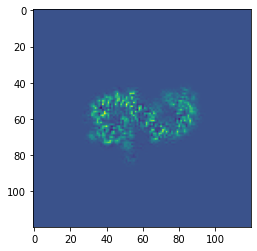

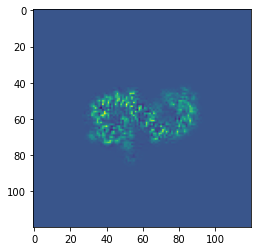

In [79]:
plt.imshow(structure[:, :, structure.shape[2] // 2])
plt.show()
plt.imshow(final_siren_output[:, :, final_siren_output.shape[2] // 2])
plt.show()

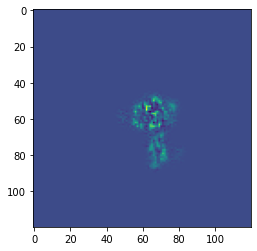

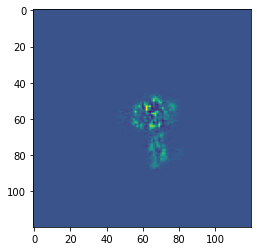

In [27]:
plt.imshow(structure[:, structure.shape[1] // 2, :])
plt.show()
plt.imshow(final_siren_output[:, final_siren_output.shape[1] // 2, :])
plt.show()

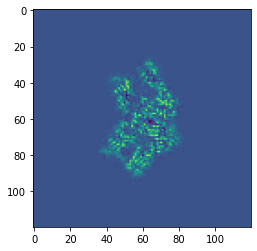

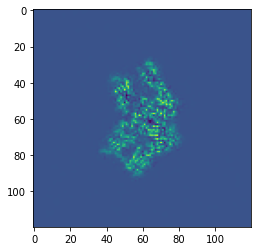

In [28]:
plt.imshow(structure[structure.shape[0] // 2, :, :])
plt.show()
plt.imshow(final_siren_output[final_siren_output.shape[0] // 2, :, :])
plt.show()

/u/jyoo/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide


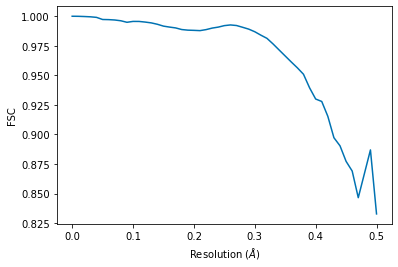

In [29]:
# Based on https://tttrlib.readthedocs.io/en/latest/auto_examples/imaging/plot_imaging_frc.html

# Arguments
shell_size = 2
epsilon = 1e-7

original_image = structure
pred_image = final_siren_output

# Calculations
F1 = np.fft.fftn(original_image.squeeze() / np.sum(original_image), axes=(0,1,2))
F2 = np.fft.fftn(pred_image.squeeze() / np.sum(pred_image), axes=(0,1,2))

F1F2 = np.real(F1 * np.conj(F2))
F1_abs_squared = np.abs(F1)**2
F2_abs_squared = np.abs(F2)**2

nx, ny, nz = F1F2.shape
x = np.arange(-np.floor(nx / 2.0), np.ceil(nx / 2.0))
y = np.arange(-np.floor(ny / 2.0), np.ceil(ny / 2.0))
z = np.arange(-np.floor(nz / 2.0), np.ceil(nz / 2.0))

distances = []
numerators = []
F1_norms = []
F2_norms = []

for xi, yi, zi in np.array(np.meshgrid(x, y, z)).T.reshape(-1, 3):
    distances.append(np.sqrt((xi ** 2) + (yi ** 2) + (zi ** 2)))
    xi = int(xi)
    yi = int(yi)
    zi = int(zi)
    
    numerators.append(F1F2[xi, yi, zi])
    F1_norms.append(F1_abs_squared[xi, yi, zi])
    F2_norms.append(F2_abs_squared[xi, yi, zi])
    
bins = np.arange(0, np.sqrt(((nx // 2) ** 2) + ((ny // 2) ** 2) + ((nz // 2) ** 2)), shell_size)
F1F2_histogram, bin_edges = np.histogram(
    distances,
    bins=bins,
    weights=numerators
)
F1_norm_histogram, bin_edges = np.histogram(
    distances,
    bins=bins,
    weights=F1_norms
)
F2_norm_histogram, bin_edges = np.histogram(
    distances,
    bins=bins,
    weights=F2_norms
)

FSC_vals = F1F2_histogram / np.sqrt(F1_norm_histogram * F2_norm_histogram)

def convert_freq_to_resolution(frequencies, px_to_A):
    resolutions = 1 / frequencies
    resolutions[resolutions == np.inf] = 0
    resolutions *= px_to_A
    
    return resolutions

# Setting up x-axis
frequencies = np.linspace(0, 0.5, num=len(FSC_vals))
px_to_A = 1.06 # rNLRP1-rDPP9 dataset specific
resolutions = convert_freq_to_resolution(frequencies, px_to_A)

# FSC_vals *= -1 # Remove later

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(frequencies, FSC_vals)
# ax.set_xticklabels(np.around(convert_freq_to_resolution(ax.get_xticks(), px_to_A), 2))
negligible_threshold_check = np.where((FSC_vals < 0.5) == True)[0]
if len(negligible_threshold_check) > 0:
    resolution = resolutions[negligible_threshold_check[0]]
    ax.axvline(x=frequencies[negligible_threshold_check[0]], color='red')
    print("Resolution:", resolution)
# ax.set_xlabel('Frequency (1/px)')
ax.set_xlabel('Resolution (' + r'$\AA$' + ')')
ax.set_ylabel('FSC')
plt.show()

In [37]:
from IPython.display import clear_output

In [65]:
desired_shape = 300

input_coords = get_mgrid(desired_shape, 3)
dataloader = DataLoader(input_coords, batch_size=1024, pin_memory=True, num_workers=0)

all_coords = []
all_densities = []

num_processed = 0
num_input = 0
for batch, model_input in enumerate(dataloader):
    clear_output()
    print(batch, '/', len(dataloader))
    
    model_input = model_input.cuda()
    
    model_output, coords = siren_model(model_input)
    all_coords.append(coords.cpu().detach().numpy().squeeze())
    # all_coords.append(model_input.cpu().detach().numpy().squeeze())
    all_densities.append(model_output.cpu().detach().numpy().squeeze())
    num_processed += len(model_output.cpu().detach().numpy().squeeze())
    num_input += len(model_input)
    
all_coords = np.concatenate(all_coords, axis=0)
all_densities = np.concatenate(all_densities, axis=0)

all_coords_transformed = np.stack(np.meshgrid(*(3 * [np.linspace(0, desired_shape - 1, desired_shape)])), axis=-1).reshape(-1, 3).astype(int)

all_coords_z = all_coords_transformed[:, 0]
all_coords_y = all_coords_transformed[:, 1]
all_coords_x = all_coords_transformed[:, 2]

final_siren_output = np.zeros((desired_shape, desired_shape, desired_shape))
final_siren_output[all_coords_y, all_coords_z, all_coords_x] = all_densities

26367 / 26368


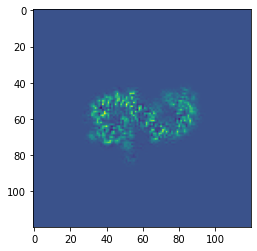

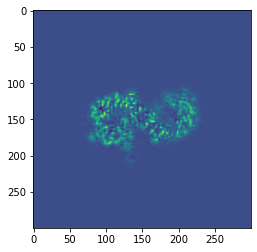

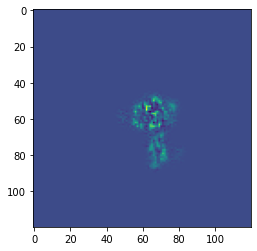

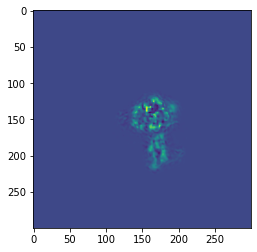

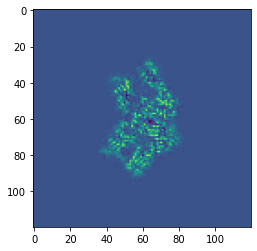

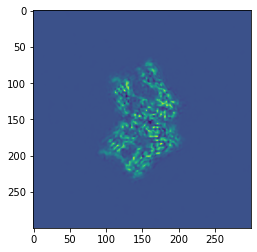

In [68]:
plt.imshow(structure[:, :, structure.shape[2] // 2])
plt.show()
plt.imshow(final_siren_output[:, :, final_siren_output.shape[2] // 2])
plt.show()
plt.imshow(structure[:, structure.shape[1] // 2, :])
plt.show()
plt.imshow(final_siren_output[:, final_siren_output.shape[1] // 2, :])
plt.show()
plt.imshow(structure[structure.shape[0] // 2, :, :])
plt.show()
plt.imshow(final_siren_output[final_siren_output.shape[0] // 2, :, :])
plt.show()

In [35]:
print(FSC_vals)

[-0.99688108 -0.99877618 -0.997641   -0.99589169 -0.99267851 -0.98837091
 -0.97876778 -0.97440783 -0.98291637 -0.98312851 -0.98538148 -0.98629274
 -0.98521396 -0.98283041 -0.97591788 -0.97051001 -0.96317327 -0.95747127
 -0.95385232 -0.96310883 -0.96606364 -0.97467892 -0.98128597 -0.98415282
 -0.98495834 -0.9830619  -0.97966565 -0.97105942 -0.96440993 -0.95122038
 -0.93321438 -0.92732615 -0.91541907 -0.89936155 -0.88393459 -0.84790611
 -0.8396665  -0.79415287 -0.46036008  0.00534331 -0.10836889]


In [80]:
with open('rNLRP1-rDPP9_siren_reconstruction_sameshape.npy', 'wb') as f:
    np.save(f, final_siren_output)

In [69]:
with open('rNLRP1-rDPP9_siren_reconstruction_300shape.npy', 'wb') as f:
    np.save(f, final_siren_output)

In [70]:
with open('rNLRP1-rDPP9_siren_reconstruction_losses.npy', 'wb') as f:
    np.save(f, np.array(loss_vals))

In [71]:
torch.save(siren_model, 'rNLRP1-rDPP9_siren_model.pt')

'''
# # Model class must be defined somewhere
model = torch.load(PATH)
model.eval()
'''

/u/jyoo/miniconda3/envs/thesis/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Siren. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/u/jyoo/miniconda3/envs/thesis/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SineLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


'\n# # Model class must be defined somewhere\nmodel = torch.load(PATH)\nmodel.eval()\n'

In [7]:
siren_model = torch.load('rNLRP1-rDPP9_siren_model.pt')
siren_model.eval()

structure = np.load('rNLRP1-rDPP9_original_structure_reduced.npy')

In [16]:
output_dims = structure.shape[0]

In [9]:
class ImageFitting(Dataset):
    def __init__(self, img, sidelength):
        super().__init__()
        img = torch.from_numpy(img)
        # self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.pixels = img.reshape(-1, 1)
        self.coords = get_mgrid(sidelength, 3)

    def __len__(self):
        return len(self.pixels)

    def __getitem__(self, idx):
        
            
        return self.coords[idx], self.pixels[idx]

In [18]:
particle_slice = ImageFitting(structure, output_dims)
dataloader = DataLoader(particle_slice, batch_size=300, pin_memory=True, num_workers=0)

In [19]:
all_coords = []
all_densities = []

for batch, data in enumerate(dataloader):
    model_input, ground_truth = data
    model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
    
    model_output, coords = siren_model(model_input)
    all_coords.append(coords.cpu().detach().numpy().squeeze())
    all_densities.append(model_output.cpu().detach().numpy().squeeze())
    
all_coords = np.concatenate(all_coords, axis=0)
all_densities = np.concatenate(all_densities, axis=0)

all_coords_transformed = np.stack(np.meshgrid(*(3 * [np.linspace(0, output_dims - 1, output_dims)])), axis=-1).reshape(-1, 3).astype(int)

all_coords_z = all_coords_transformed[:, 0]
all_coords_y = all_coords_transformed[:, 1]
all_coords_x = all_coords_transformed[:, 2]

final_siren_output = np.zeros((output_dims, output_dims, output_dims))
final_siren_output[all_coords_y, all_coords_z, all_coords_x] = all_densities

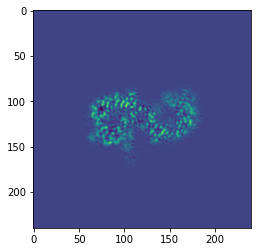

In [15]:
create_structure_from_scratch = True

if create_structure_from_scratch: 
    # Getting test rNLRP1-rDPP9 map
    map_filename = 'emd_30458.map.gz'
    map_path = map_filename.replace('.gz', '')
    if not os.path.exists(map_filename):
        !wget ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-30458/map/emd_30458.map.gz
    if not os.path.exists(map_path):
        !gunzip 'emd_30458.map.gz'

    # https://bioinformatics.stackexchange.com/questions/13079/ccp4-file-to-a-python-3-numpy-array-or-similar-workaround
    test_map = gemmi.read_ccp4_map('emd_30458.map')
    test_map.setup()  # optional

    raw_structure = np.array(test_map.grid, copy=False)
    plt.imshow(raw_structure[:, :, raw_structure.shape[0] // 2])
    
    structure = np.expand_dims(raw_structure, axis=-1)
    # structure = structure[50:-50, 50:-50, 50:-50, :]
    # structure = scipy.ndimage.zoom(structure, (0.5, 0.5, 0.5, 1))
    
    # with open('rNLRP1-rDPP9_original_structure_reduced.npy', 'wb') as f:
    #     np.save(f, structure)
else:
    structure = np.load('rNLRP1-rDPP9_original_structure_reduced.npy')

px_to_A = 1.06 # TRPV1 dataset specific

/u/jyoo/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/u/jyoo/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/u/jyoo/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator


Resolution: 6.36


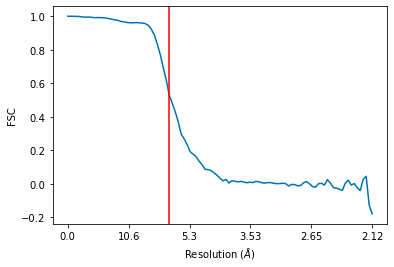

In [20]:
# Based on https://tttrlib.readthedocs.io/en/latest/auto_examples/imaging/plot_imaging_frc.html

# Arguments
shell_size = 2
epsilon = 1e-7

original_image = structure
pred_image = final_siren_output

# Calculations
F1 = np.fft.fftn(original_image.squeeze() / np.sum(original_image), axes=(0,1,2))
F2 = np.fft.fftn(pred_image.squeeze() / np.sum(pred_image), axes=(0,1,2))

F1F2 = np.real(F1 * np.conj(F2))
F1_abs_squared = np.abs(F1)**2
F2_abs_squared = np.abs(F2)**2

nx, ny, nz = F1F2.shape
x = np.arange(-np.floor(nx / 2.0), np.ceil(nx / 2.0))
y = np.arange(-np.floor(ny / 2.0), np.ceil(ny / 2.0))
z = np.arange(-np.floor(nz / 2.0), np.ceil(nz / 2.0))

distances = []
numerators = []
F1_norms = []
F2_norms = []

for xi, yi, zi in np.array(np.meshgrid(x, y, z)).T.reshape(-1, 3):
    distances.append(np.sqrt((xi ** 2) + (yi ** 2) + (zi ** 2)))
    xi = int(xi)
    yi = int(yi)
    zi = int(zi)
    
    numerators.append(F1F2[xi, yi, zi])
    F1_norms.append(F1_abs_squared[xi, yi, zi])
    F2_norms.append(F2_abs_squared[xi, yi, zi])
    
bins = np.arange(0, np.sqrt(((nx // 2) ** 2) + ((ny // 2) ** 2) + ((nz // 2) ** 2)), shell_size)
F1F2_histogram, bin_edges = np.histogram(
    distances,
    bins=bins,
    weights=numerators
)
F1_norm_histogram, bin_edges = np.histogram(
    distances,
    bins=bins,
    weights=F1_norms
)
F2_norm_histogram, bin_edges = np.histogram(
    distances,
    bins=bins,
    weights=F2_norms
)

FSC_vals = F1F2_histogram / np.sqrt(F1_norm_histogram * F2_norm_histogram)

def convert_freq_to_resolution(frequencies, px_to_A):
    resolutions = 1 / frequencies
    resolutions[resolutions == np.inf] = 0
    resolutions *= px_to_A
    
    return resolutions

# Setting up x-axis
frequencies = np.linspace(0, 0.5, num=len(FSC_vals))
px_to_A = 1.06 # rnlrp1 dataset specific
resolutions = convert_freq_to_resolution(frequencies, px_to_A)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(frequencies, FSC_vals)
ax.set_xticklabels(np.around(convert_freq_to_resolution(ax.get_xticks(), px_to_A), 2))
negligible_threshold_check = np.where((FSC_vals < 0.5) == True)[0]
if len(negligible_threshold_check) > 0:
    resolution = resolutions[negligible_threshold_check[0] - 1]
    ax.axvline(x=frequencies[negligible_threshold_check[0] - 1], color='red')
    print("Resolution:", resolution)
# ax.set_xlabel('Frequency (1/px)')
ax.set_xlabel('Resolution (' + r'$\AA$' + ')')
ax.set_ylabel('FSC')
plt.show()

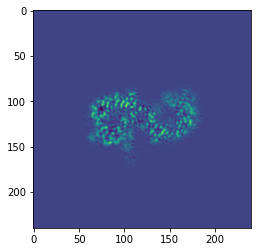

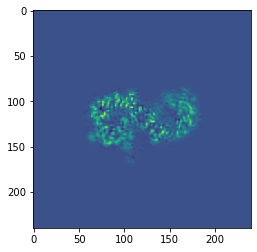

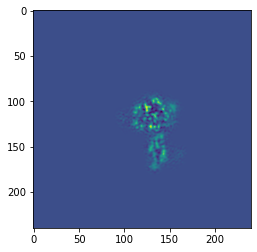

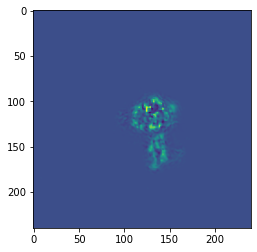

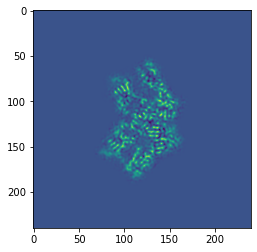

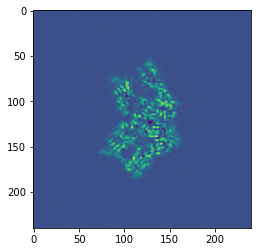

In [21]:
plt.imshow(structure[:, :, structure.shape[2] // 2])
plt.show()
plt.imshow(final_siren_output[:, :, final_siren_output.shape[2] // 2])
plt.show()
plt.imshow(structure[:, structure.shape[1] // 2, :])
plt.show()
plt.imshow(final_siren_output[:, final_siren_output.shape[1] // 2, :])
plt.show()
plt.imshow(structure[structure.shape[0] // 2, :, :])
plt.show()
plt.imshow(final_siren_output[final_siren_output.shape[0] // 2, :, :])
plt.show()